In [13]:
!pip install -q torch torchvision torchaudio
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/IMDB Dataset.csv
/content/.config/config_sentinel
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_survey_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/gce
/content/.config/active_config
/content/.config/default_configs.db
/content/.config/logs/2023.10.10/13.28.26.866497.log
/content/.config/logs/2023.10.10/13.28.36.275004.log
/content/.config/logs/2023.10.10/13.28.37.050411.log
/content/.config/logs/2023.10.10/13.28.19.429721.log
/content/.config/logs/2023.10.10/13.27.44.027318.log
/content/.config/logs/2023.10.10/13.28.09.725828.log
/content/.config/configurations/config_default
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_test.csv


In [6]:
df = pd.read_csv('/content/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Spling Test and Training Dataset

In [7]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


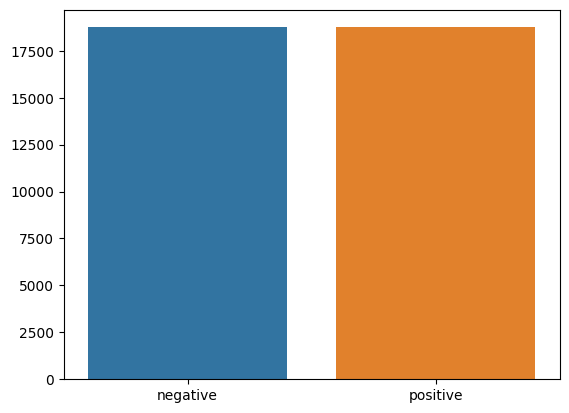

In [8]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

Tokenization

In [14]:
from transformers import BertModel, BertTokenizer, AdamW
from torch.utils.data import Dataset, DataLoader

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


class SentimentBERT(nn.Module):
    def __init__(self):
        super(SentimentBERT, self).__init__()
        self.bert_layer = bert_model

        # Classification layer
        self.cls_layer = nn.Linear(768, 1)

    def forward(self, seq, attn_masks):
        outputs = self.bert_layer(seq, attention_mask=attn_masks)
        cls_rep = outputs.last_hidden_state[:, 0]
        logits = self.cls_layer(cls_rep)

        return logits

model = SentimentBERT().to(device)


In [15]:
# Prepare data for BERT (Tokenization and attention masks)
def prepare_data_for_bert(data):
    ids_list=[]
    mask_list=[]

    for review in data:
      tokens=tokenizer.encode(review,max_length=512,truncation=True,padding='max_length')
      ids_list.append(tokens)
      mask=[int(token>0) for token in tokens]
      mask_list.append(mask)

    return ids_list,mask_list


In [16]:
x_train_ids,x_train_mask=prepare_data_for_bert(x_train)
x_test_ids,x_test_mask=prepare_data_for_bert(x_test)

y_train_encoded=[1 if label =='positive' else 0 for label in y_train]
y_test_encoded=[1 if label =='positive' else 0 for label in y_test]


In [17]:
# Create Tensor datasets and dataloaders
train_dataset=TensorDataset(torch.tensor(x_train_ids),torch.tensor(x_train_mask),torch.tensor(y_train_encoded))
test_dataset=TensorDataset(torch.tensor(x_test_ids),torch.tensor(x_test_mask),torch.tensor(y_test_encoded))

batch_size=16

train_dataloader=DataLoader(train_dataset,batch_size=batch_size)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size)

In [22]:
criterion=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=.001)

epochs=5
for epoch_i in range(epochs):

  total_loss,total_accuracy,total_val_loss,total_val_accuracy=[],[],[],[]

  model.train()

  # For each batch of training data...
  for step,batch in enumerate(train_dataloader):

    b_input_id=batch[0].to(device)
    b_input_mask=batch[1].to(device)
    b_labels=batch[2].to(device).float()

     # Zero out any previously calculated gradients.
    model.zero_grad()

     # Perform a forward pass. This will return logits.
    logits=model(b_input_id,b_input_mask)

     # Compute loss and accumulate the loss values.

    loss=criterion(logits.squeeze(),b_labels)
    total_loss.append(loss.item())

     # Perform a backward pass to calculate gradients.
    loss.backward()

     # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

     # Update parameters and the learning rate.
    optimizer.step()

     # Calculate accuracy
    accuracy=((logits>0)==b_labels).cpu().numpy().mean()*100
    total_accuracy.append(accuracy)

  avg_train_loss=sum(total_loss)/len(total_loss)
  avg_train_accuracy=sum(total_accuracy)/len(total_accuracy)

  print('Average Training Loss:',avg_train_loss)
  print('Average Training Accuracy:',avg_train_accuracy)

  model.eval()

Average Training Loss: 0.7015025678246501
Average Training Accuracy: 50.03732935153584
Average Training Loss: 0.6950704695167395
Average Training Accuracy: 50.044661902730375
Average Training Loss: 0.6943083444654738
Average Training Accuracy: 50.09065699658703
Average Training Loss: 0.6940388158980897
Average Training Accuracy: 50.02499733361775
Average Training Loss: 0.6939096210251082
Average Training Accuracy: 50.187313353242324


Evaluation and Inference

In [25]:
# Inference on New Data
def predict_sentiment(model, sentence):
    model.eval()

    # Tokenize the sentence
    tokens=tokenizer.encode(sentence,max_length=512,truncation=True,padding='max_length')

    # Convert to tensor format and move to GPU if available
    ids_tensor=torch.tensor(tokens).unsqueeze(0).to(device)
    mask_tensor=torch.tensor([int(token>0) for token in tokens]).unsqueeze(0).to(device)

    # Forward pass through the model
    with torch.no_grad():
        output=model(ids_tensor,mask_tensor)

    # Apply sigmoid function to output and return label
    prediction=torch.sigmoid(output.squeeze()).item()

    if prediction > 0.5:
        return 'positive'
    else:
        return 'negative'



In [26]:
# Call function to make a prediction on new data
print(predict_sentiment(model, "This movie was really great!"))

negative
